# Table of Contents

1. [Import Packages](#import-packages)
2. [Import Mouse Metadata](#import-mouse-metadata)
3. [Import Level-1 CSV file](#import-level-1-csv-file)
4. [Data Stream 1: KDE](#data-stream-1-kernel-density-estimation-kde)
5. [Data Stream 2: Targeted Angle](#data-stream-2-targeted-angle)
6. [Data Stream 3: Value-based Distance](#data-stream-3-value-based-distance)
<br>&nbsp;&nbsp;&nbsp;&nbsp;6.1. [Spatial Embedding](#spatial-embedding-across-the-maze-based-on-value-map)
7. [Run CoMPASS Level-2](#run-compass-level-2)
8. [Save output file](#save-output-file)

# Import Packages

In [47]:
import numpy as np
import pandas as pd
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# autoreload 
%load_ext autoreload
%autoreload 2

In [ ]:
# Correct path: add the directory that contains `level_2`
CUSTOM_UTILS_PATH = Path(os.getcwd()).parent / 'src' / 'compass'
sys.path.append(str(CUSTOM_UTILS_PATH))

try:
    import level_2
    print("Utils loaded successfully!")
except ImportError as e:
    print(f"Warning: Could not import custom modules: {e}")

import init_config
from init_config import *

import notebook_utils
from notebook_utils import * 

In [42]:
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['pdf.fonttype'] = 42

# Import Mouse Metadata

In [ ]:
# Read in mouse metadata file
mouseinfo = pd.read_excel(os.path.join(METADATA_PATH,METADATA_FILE), sheet_name=TRIAL_TYPE)
print('Metadata columns: ',mouseinfo.columns)

# Consider only non-NA Sessions
mouseinfo = mouseinfo[~mouseinfo['Session #'].isna()]

# Find the subset of trials need to be excluded
mouseinfo = mouseinfo.loc[mouseinfo['Exclude Trial']!= 'yes'].reset_index(drop=True)

# Import Level-1 CSV file

In [18]:
df_hmm = pd.read_csv(os.path.join(BASE_PATH,'csvs','combined','HMM_2state_file.csv'))

# Data Stream 1: Kernel Density Estimation (KDE)

In [57]:
# =================== USAGE EXAMPLE =================== #
# This workflow optimizes and applies kernel density estimation (KDE) to spatial
# navigation data using Leave-One-Session-Out (LOSO) cross-validation.
# It selects the best spatial smoothing parameter (sigma), computes session-wise
# KDE values, and visualizes the resulting density maps.
# ========================================================= #


#----------SET THESE VALUES---------#

# Step 1: Define bandwidth search space
smoothing_factors = [0.5, 1, 2, 3, 4, 5]

#___________________________________________________________
# Step 2: Run LOSO CV to get best sigma
best_sigma = level_2.loso_kde_cv(df_hmm, smoothing_factors)

# Step 3: Compute KDE using optimal sigma
df_hmm = level_2.compute_kde_scaled(df_hmm, best_sigma)

# Step 4: Visualize KDE maps
level_2.plot_kde_per_session(df_hmm, best_sigma)


Testing for sigma =  0.5
Testing for sigma =  1
Testing for sigma =  2
Testing for sigma =  3
Testing for sigma =  4
Testing for sigma =  5
Best Sigma =  0.5
Computing KDE for Session 3...
Computing KDE for Session 4...
Computing KDE for Session 5...
Computing KDE for Session 6...
Computing KDE for Session 7...


AttributeError: module 'matplotlib.mlab' has no attribute 'griddata'

# Data Stream 2: Targeted Angle

In [ ]:
# =================== USAGE EXAMPLE =================== #
# This workflow computes the angular deviation of the animal's movement
# from a defined reference axis for each grid location in the maze.
# It incorporates spatial smoothing by mapping each grid to a reference node,
# calculates mean node positions, and derives angular deviation vectors session-wise.
# ========================================================= #


#----------SET THESE VALUES---------#
ROLLING_WINDOW = 5
# CLOSE_REF = { ... }       # Your predefined grid node to anchor mapping (SPECIFIED IN COMPASS_CONFIG)
# X_Y_MAPPING = { ... }     # Your predefined grid to axis mapping (SPECIFIED IN COMPASS_CONFIG)

#__________________________________________________

# ------------------ Step 1: Reference Info ------------------ #
df_hmm = level_2.assign_reference_info(df_hmm, level_2.CLOSE_REF, level_2.X_Y_MAPPING)

# ------------------ Step 2: Unsmoothed Deviation ------------------ #
df_dev = level_2.compute_unsmoothed_angle_deviation(df_hmm)

# ------------------ Step 3: Smoothed Deviation ------------------ #
df_dev = level_2.compute_smoothed_angle_deviation(df_dev, rolling_window=ROLLING_WINDOW)

# Data Stream 3: Value-based Distance

In [ ]:
# ======================= USAGE EXAMPLE ======================= #
# This workflow computes a normalized, value-weighted distance of each 
# animal position from a central target region (e.g., Grid 84 and 85). 
# This metric can be used to quantify how spatially aligned behavior 
# is with goal-relevant zones.
# ========================================================= #


#----------SET THESE VALUES---------#
# VALUE_MAP_PATH = r'C:\Users\....'   # Specified in compass_config 

#__________________________________________________
# Run the value distance computation pipeline
df_hmm = level_2.compute_value_distance(df_hmm, value_map_path=level_2.VALUE_MAP_PATH, center_grids=[84, 85])

## Spatial Embedding across the maze (based on Value-map)

In [ ]:
# --------------------- STEP 1: Compute Smoothed Spatial Embedding --------------------- #
# Apply spatial smoothing over the dataframe using a Gaussian kernel (sigma = 2)
# This function generates a local average of behavioral or positional metrics
df_smoothed = level_2.compute_spatial_embedding(df_hmm, sigma=2)

# --------------------- STEP 2: Convert Smoothed Data to Grid Format --------------------- #
embedding_grid = level_2.create_embedding_grid(df_smoothed)

# --------------------- STEP 3: Visualize Spatial Embedding as Heatmap --------------------- #
# Plot a heatmap of the smoothed behavioral embedding
level_2.plot_spatial_embedding(embedding_grid)


# Run CoMPASS Level-2

In [ ]:
df_hier, cv_results = level_2.run_compass(
    df_hmm,
    features = ['HMM_State','VB_Distance','Targeted_Angle_smooth_abs','KDE'],
    phase_options=[5], # different phase options can be tested out
    ncomp_options=range(2, 4),
    k_options=range(2, 4),
    reg_options=[1e-4, 1e-5, 1e-6],
    terminal_values=[47], # entry node --> starting point
    bout_col='Bout_ID',
    patience=None,
    patience_candidates=[2, 3, 5, 10] # (only used if patience == 'tune')
)

# (Optional) Visualize CV results

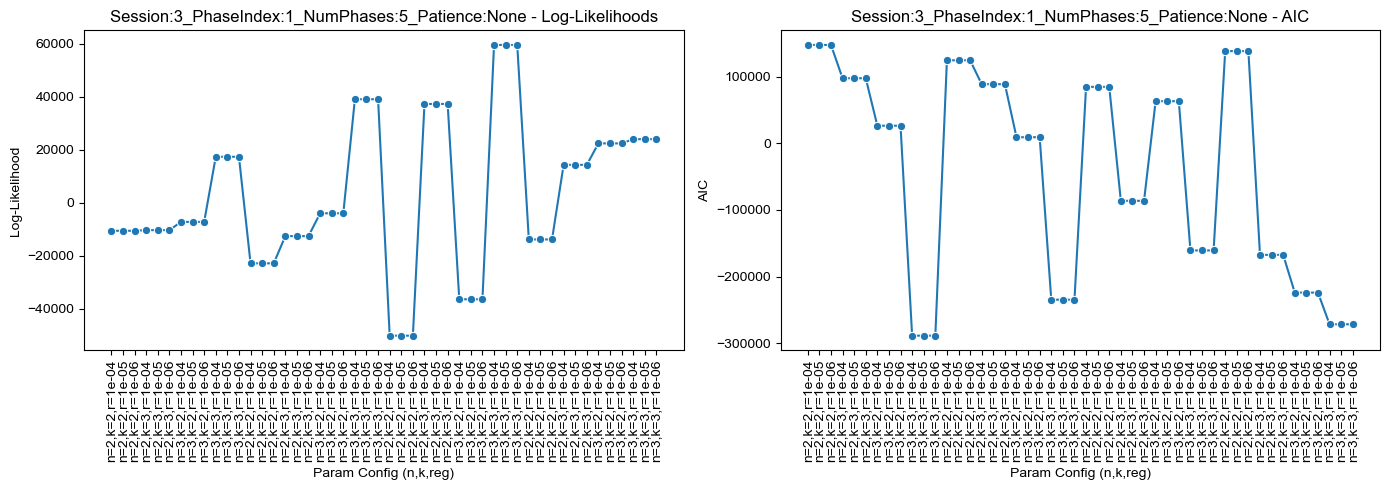

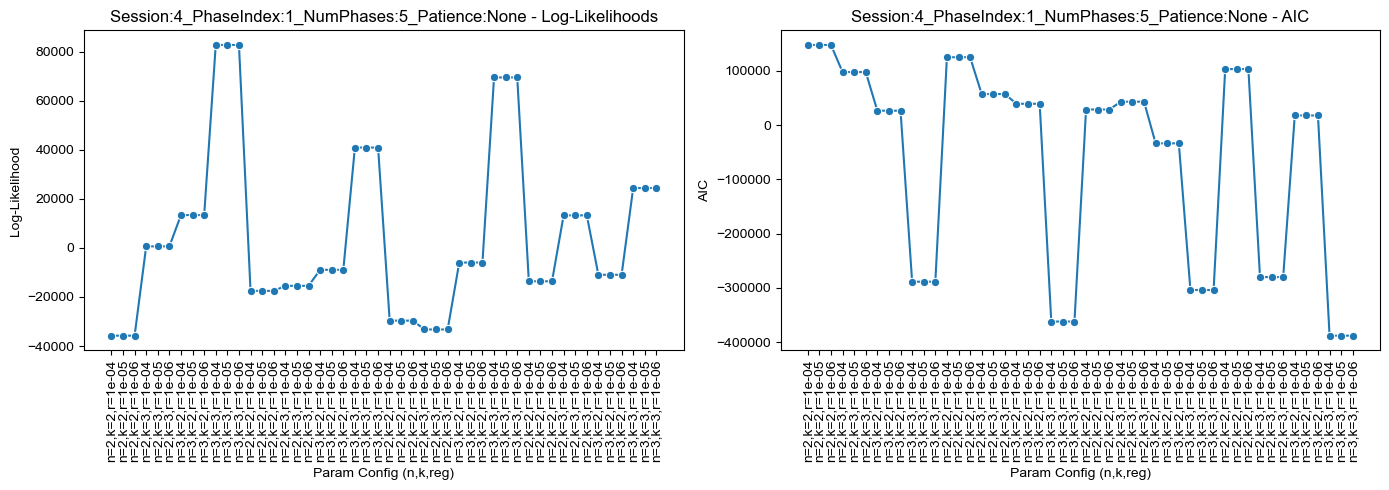

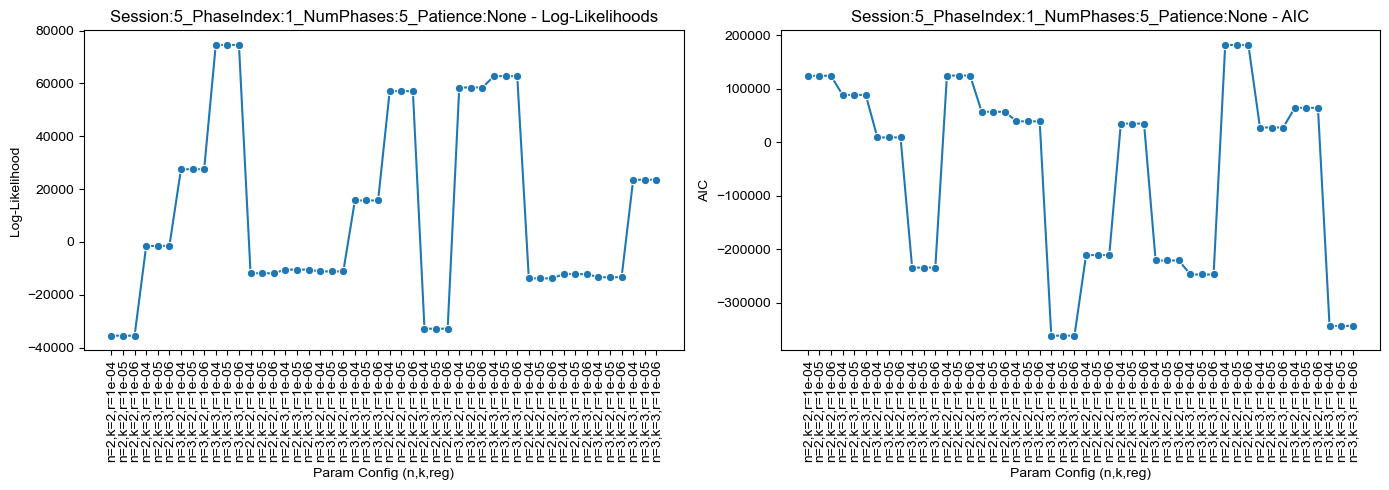

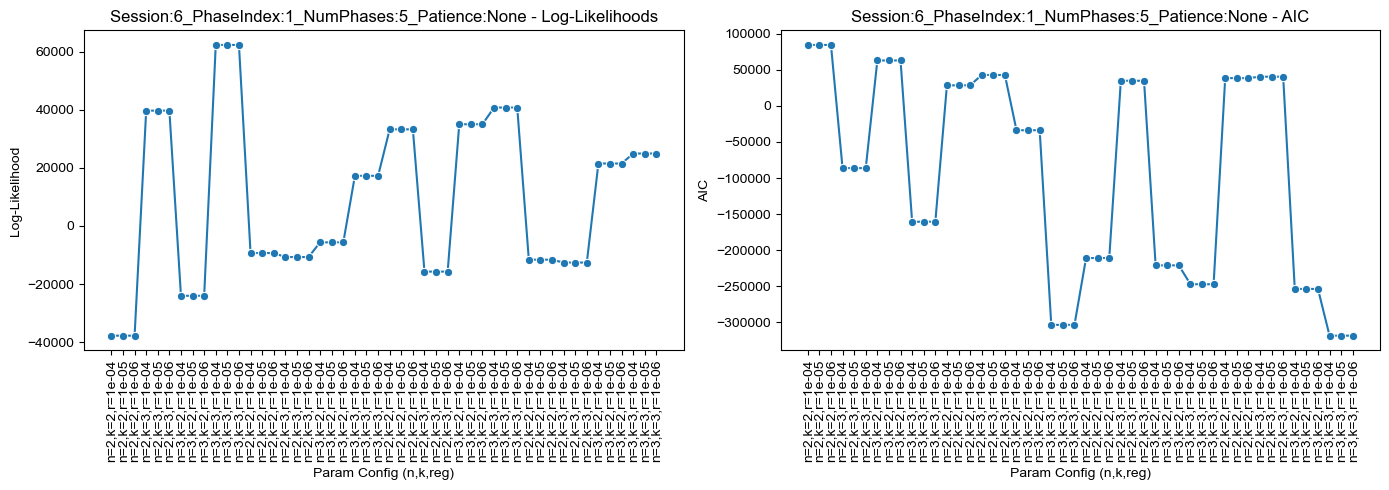

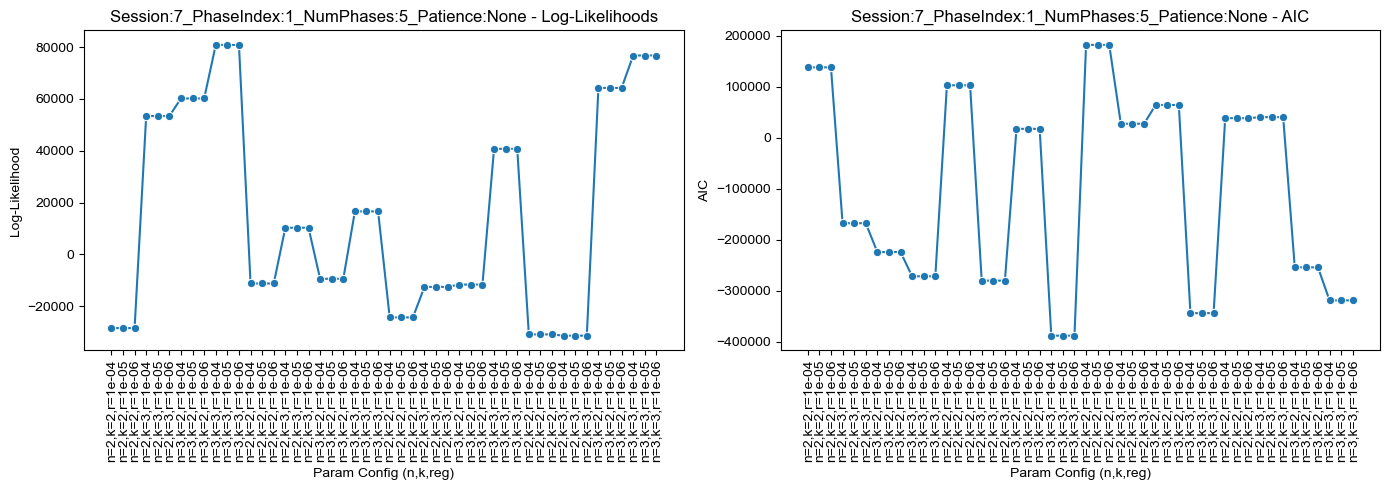

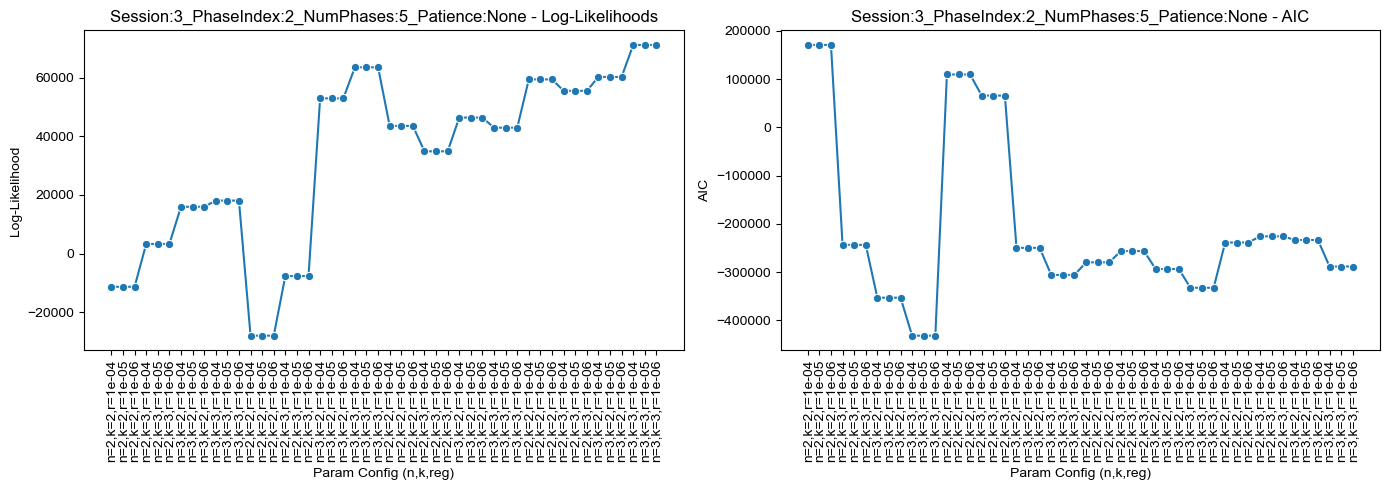

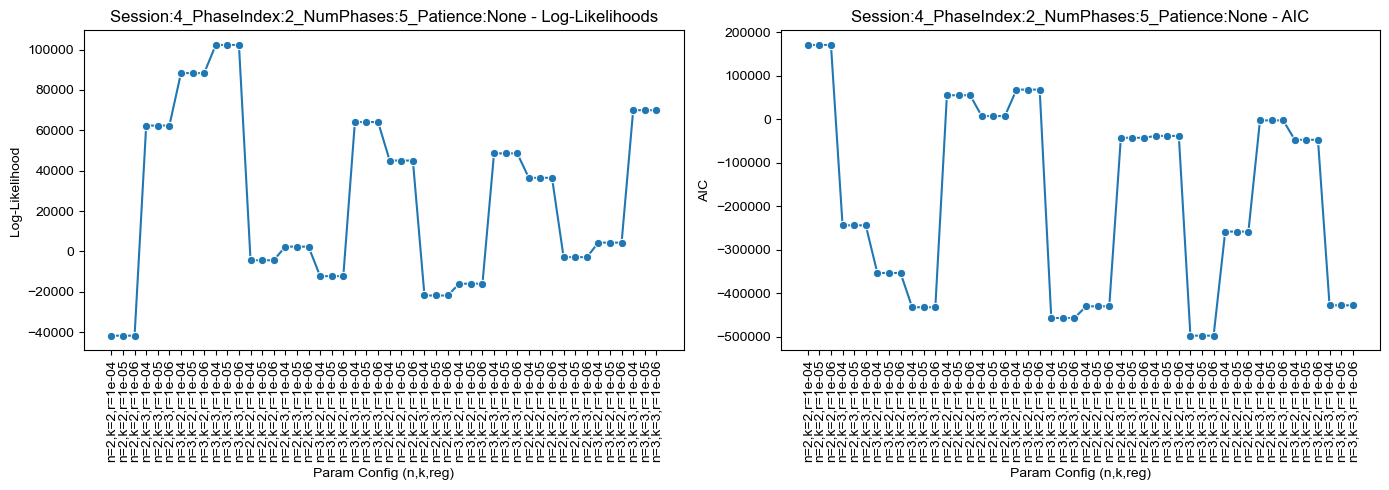

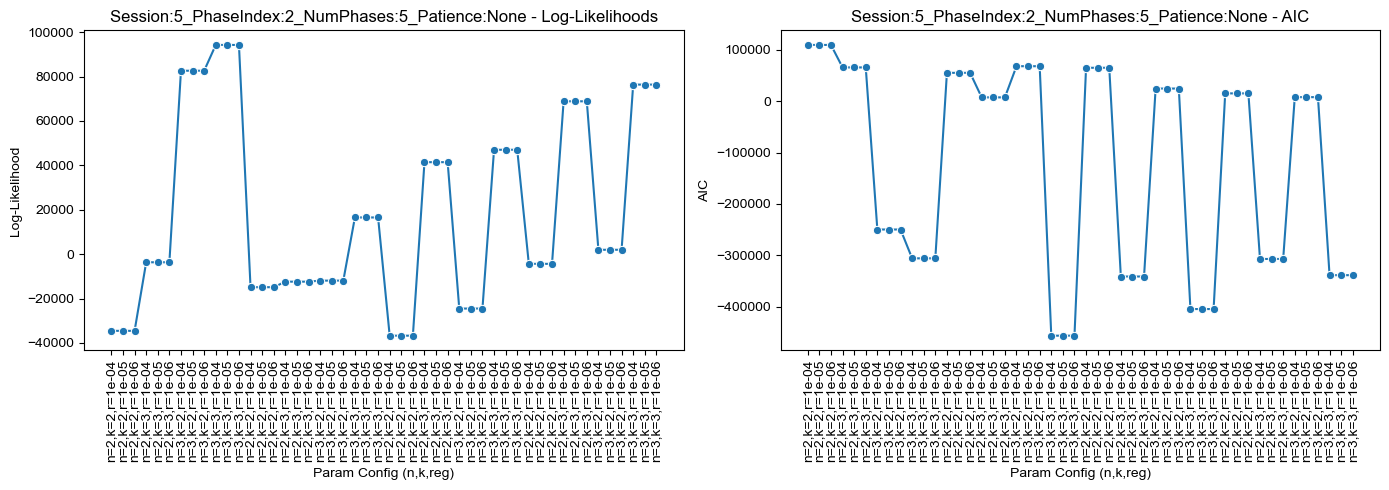

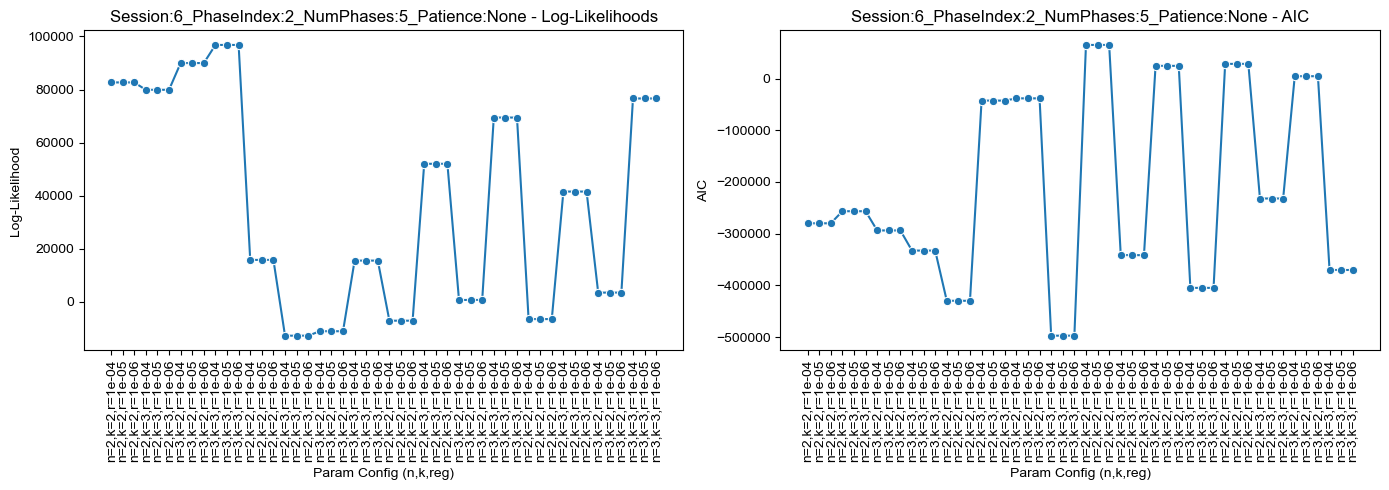

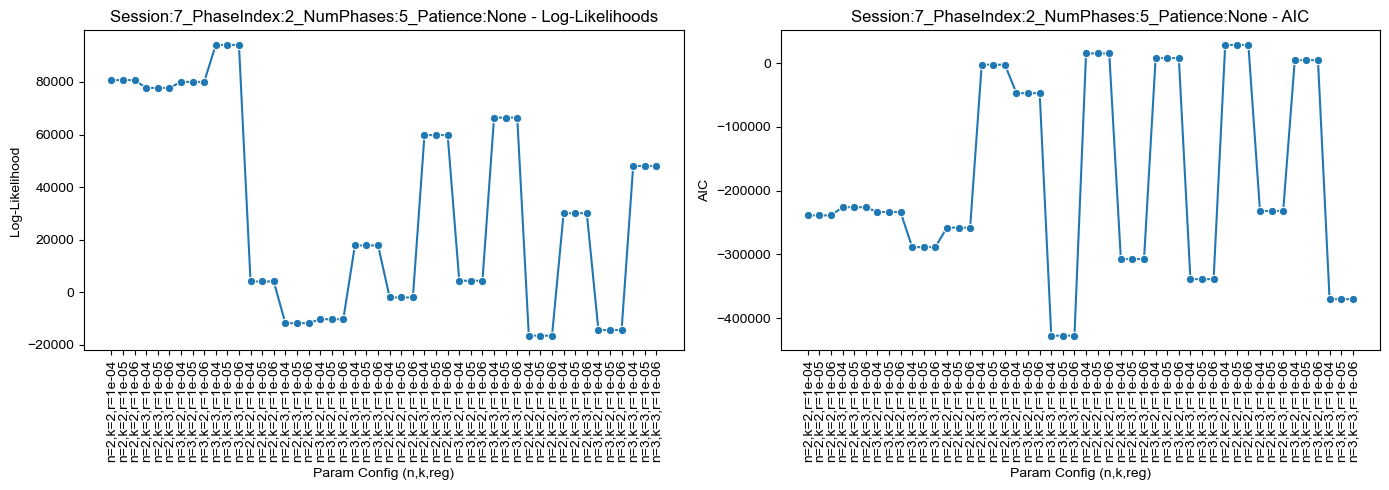

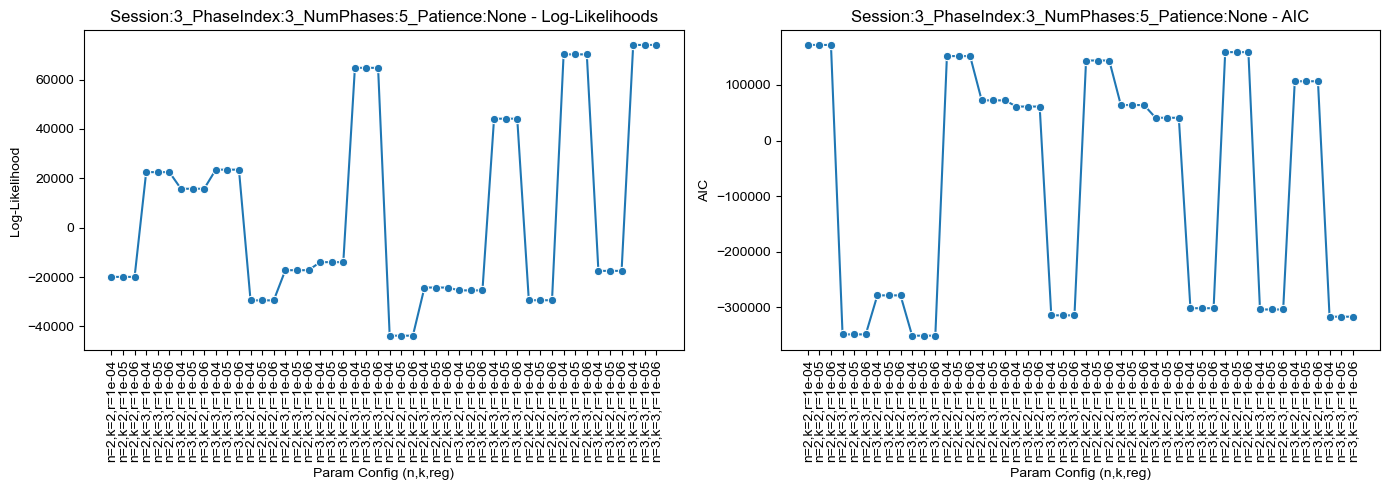

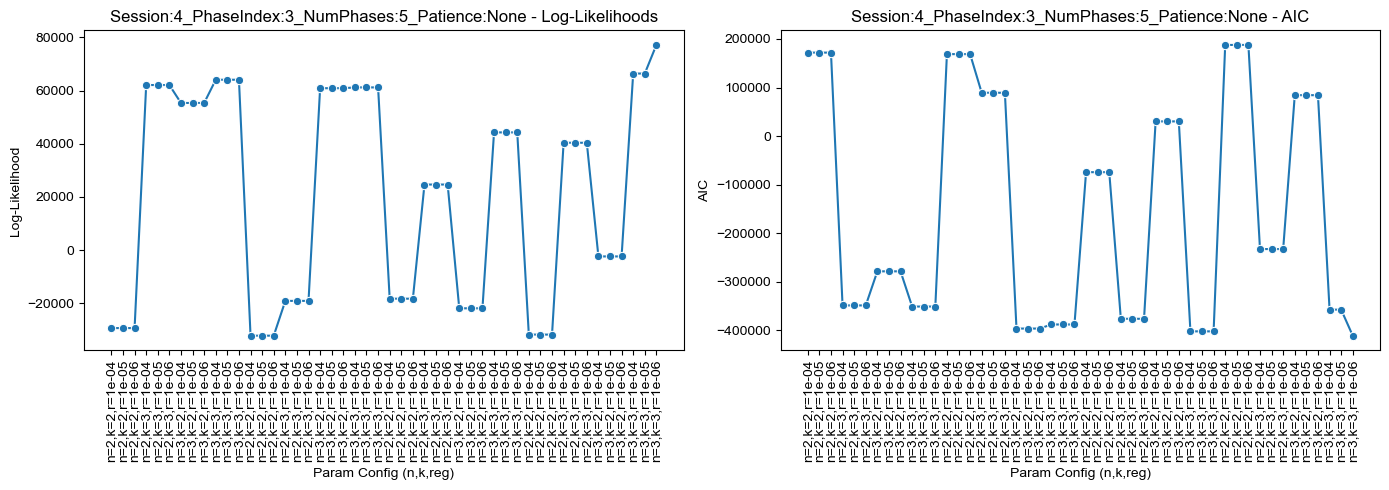

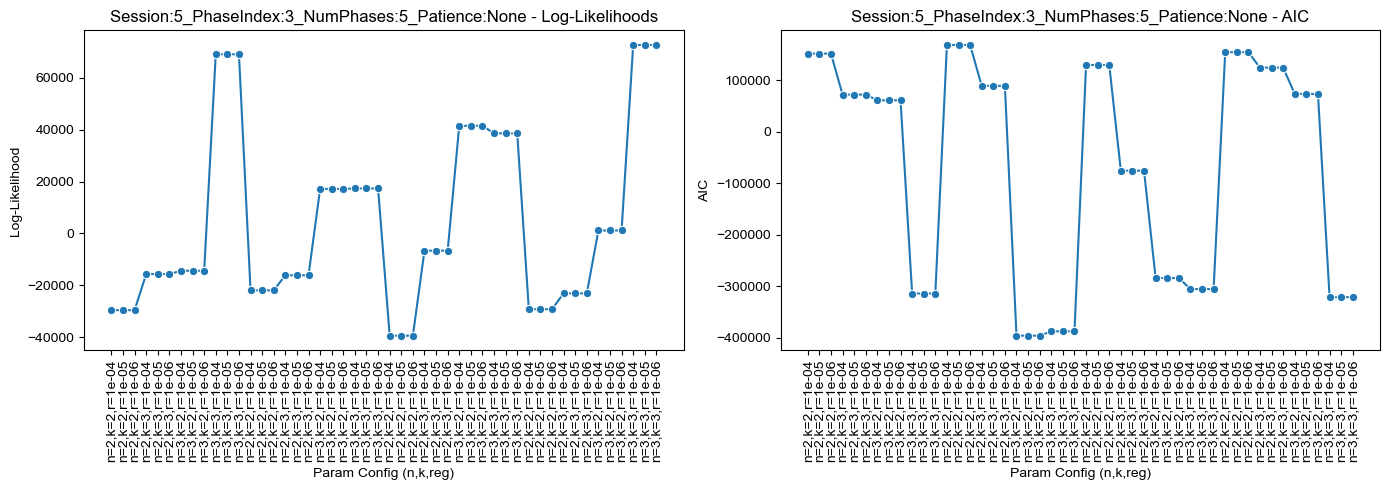

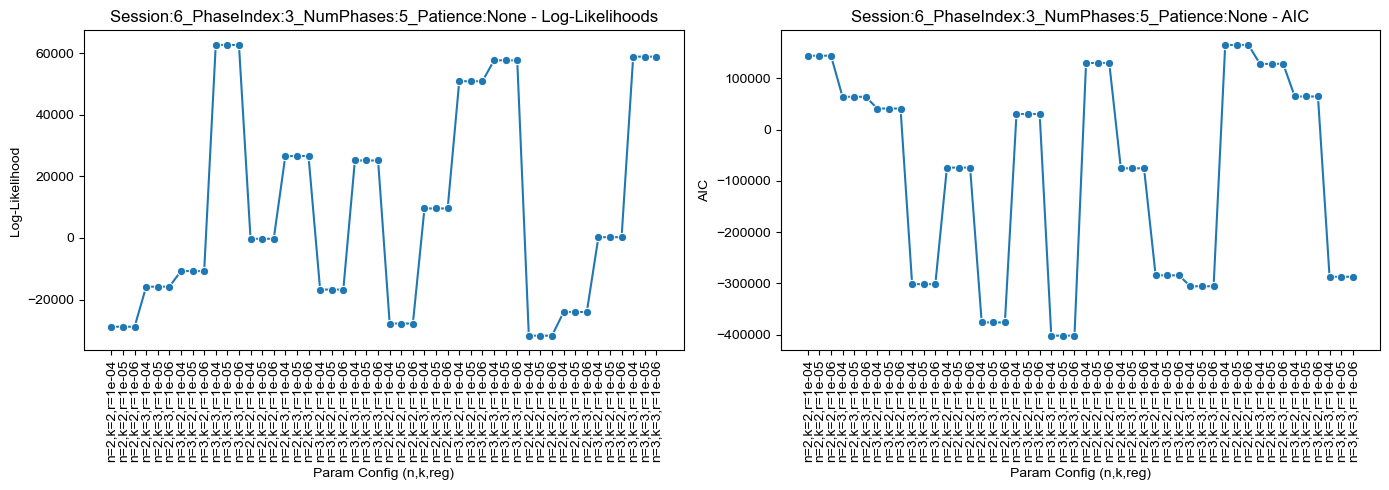

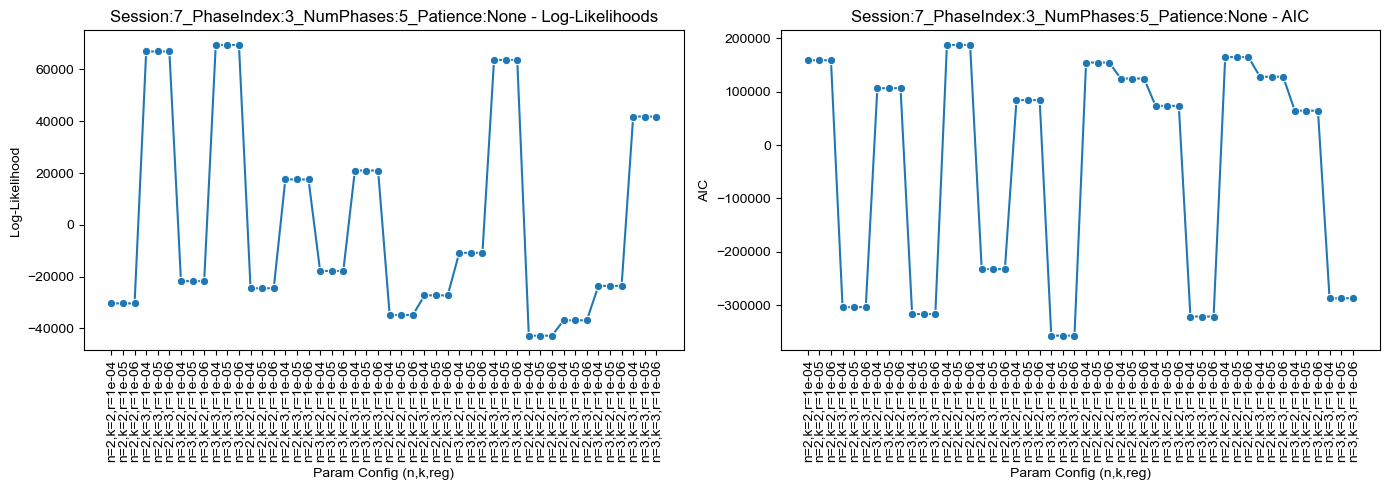

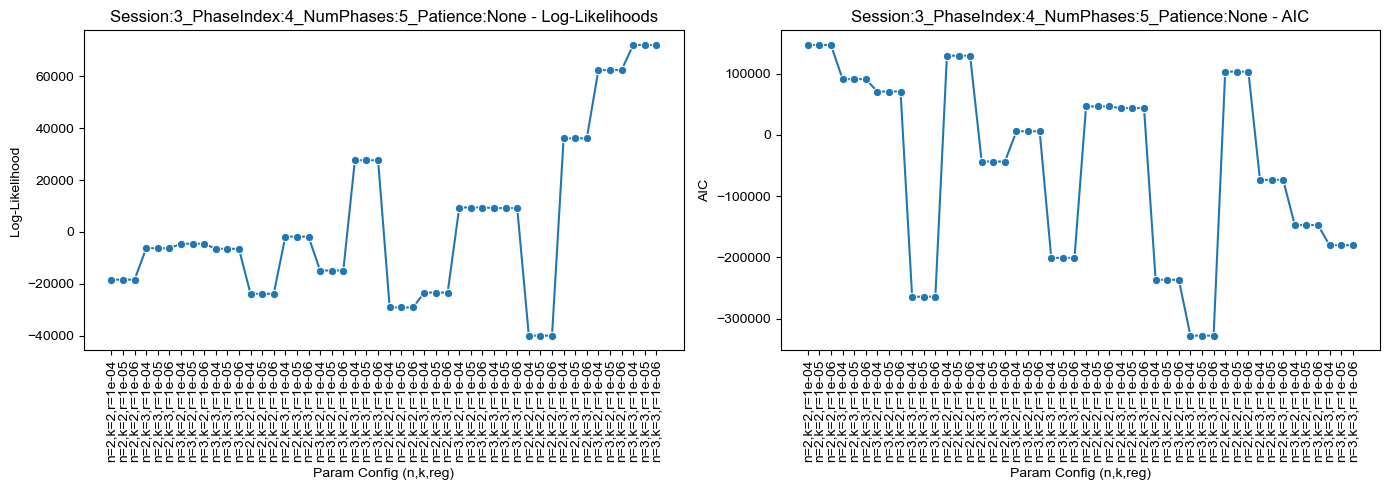

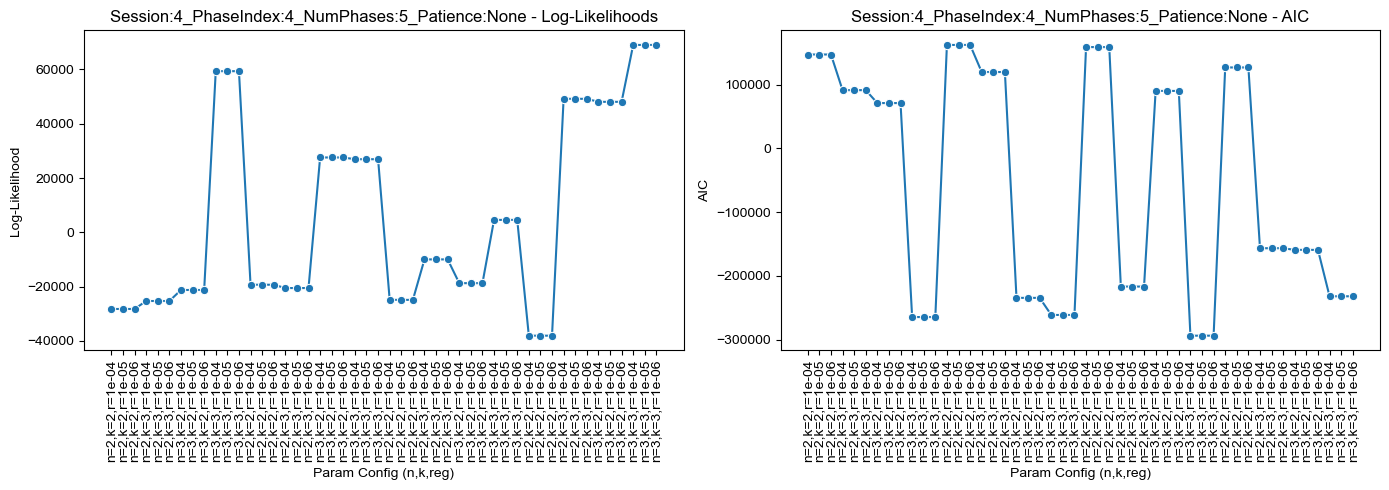

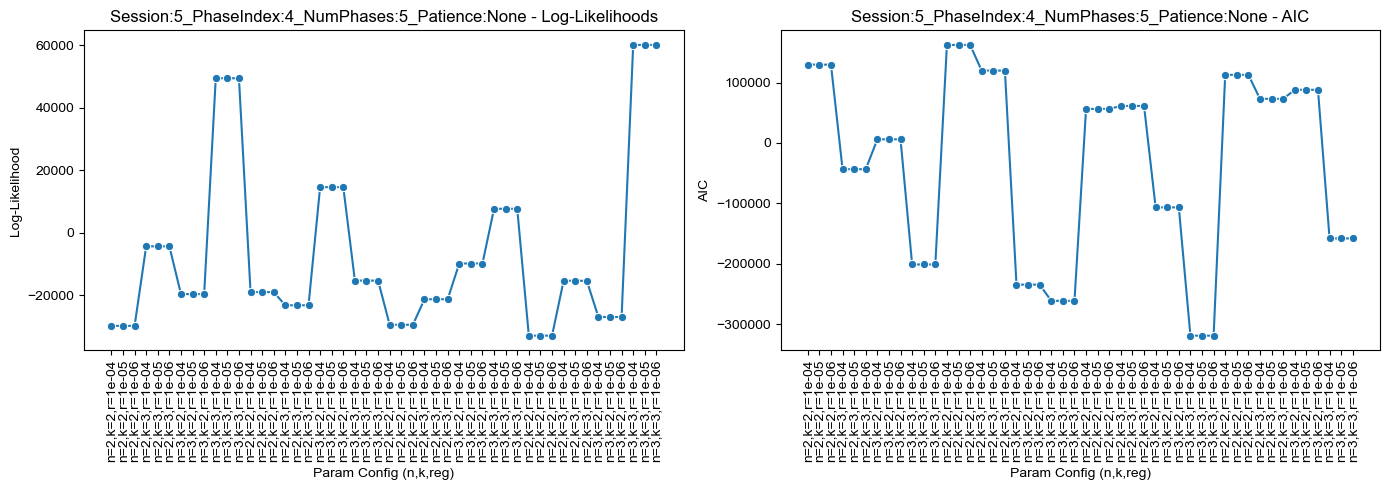

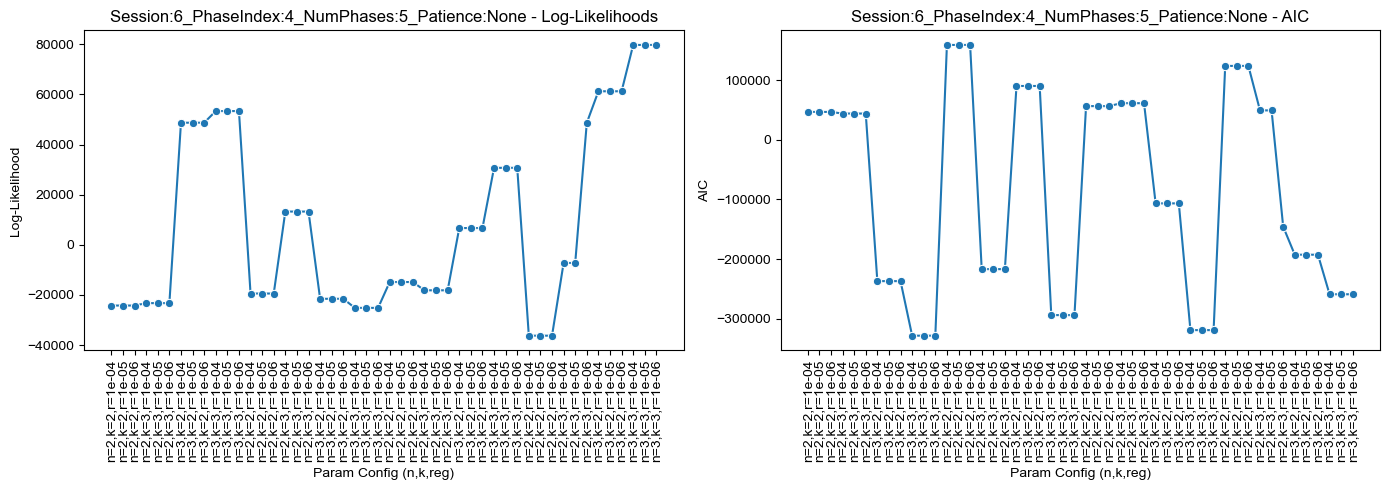

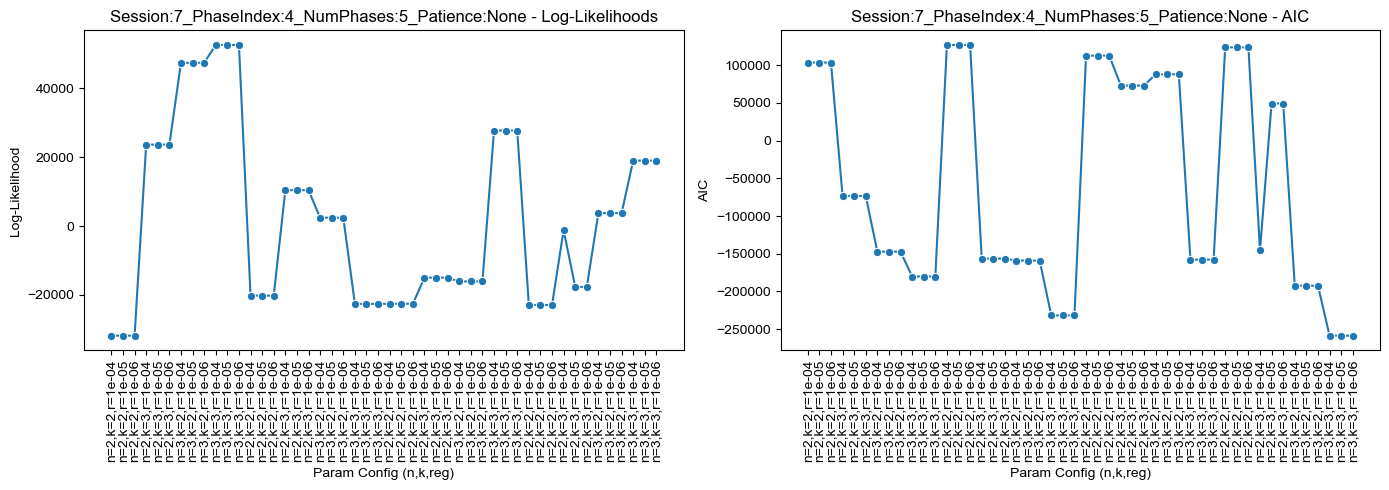

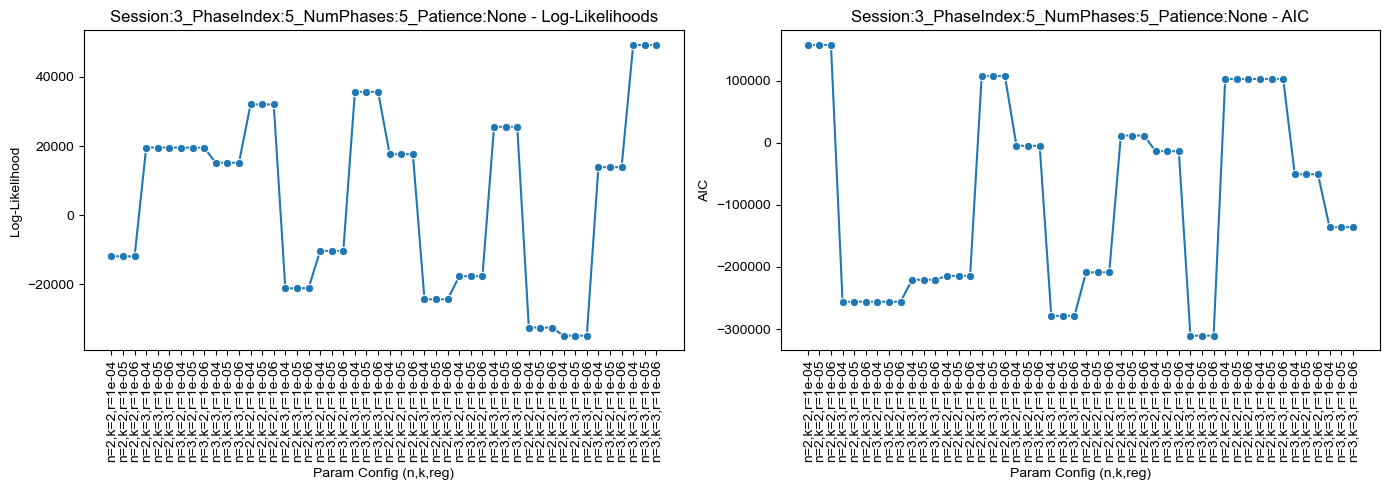

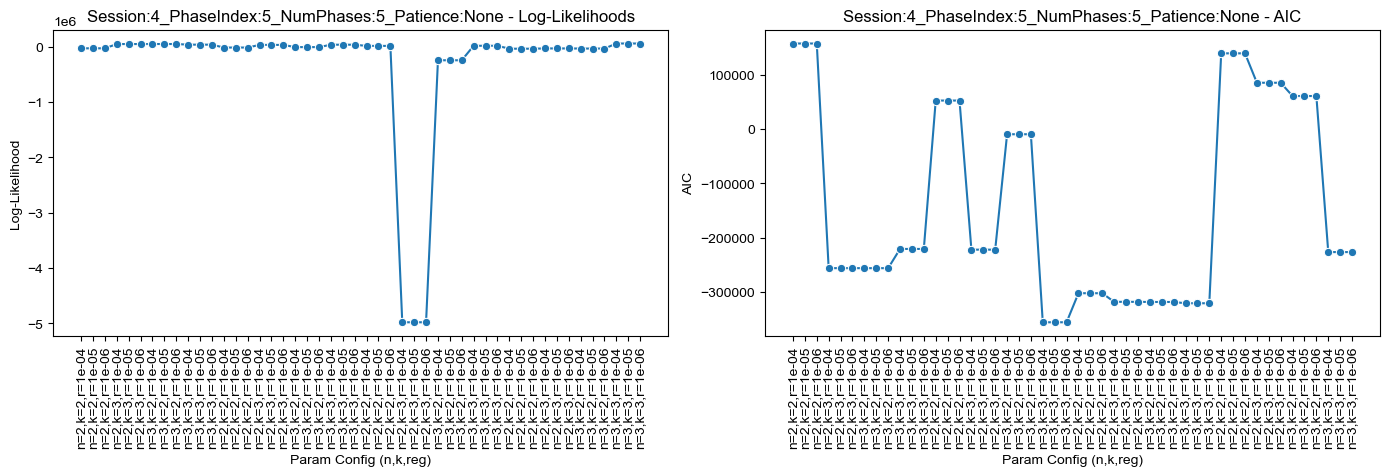

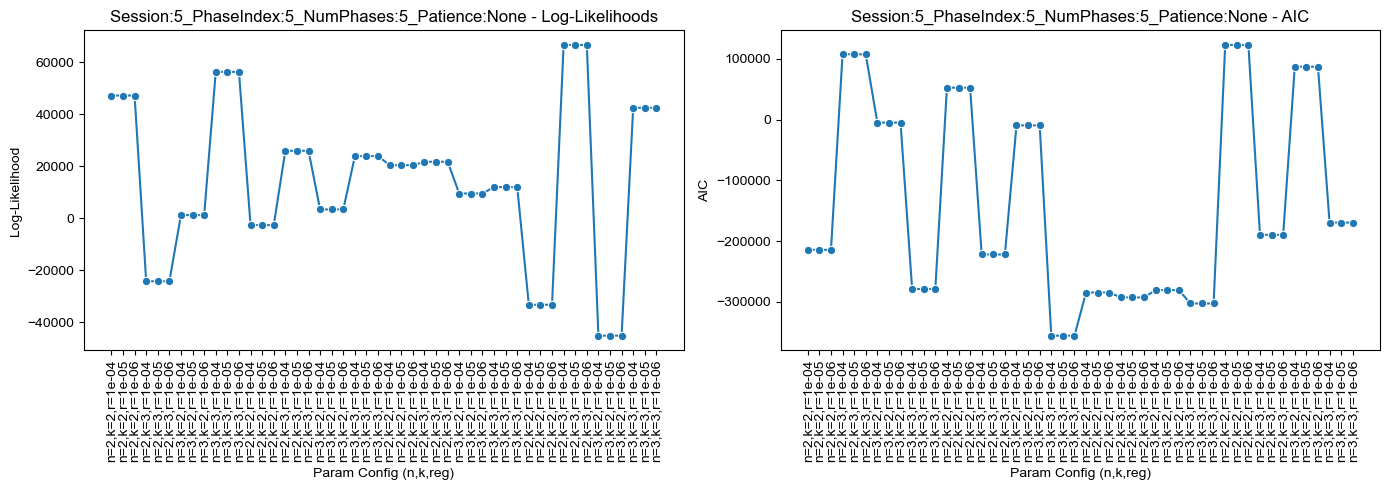

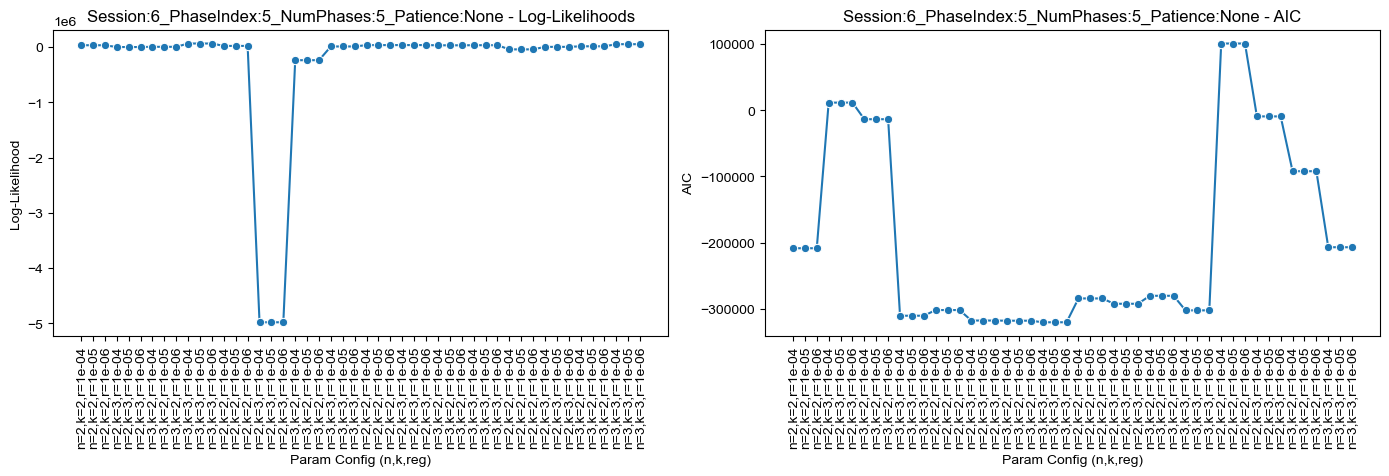

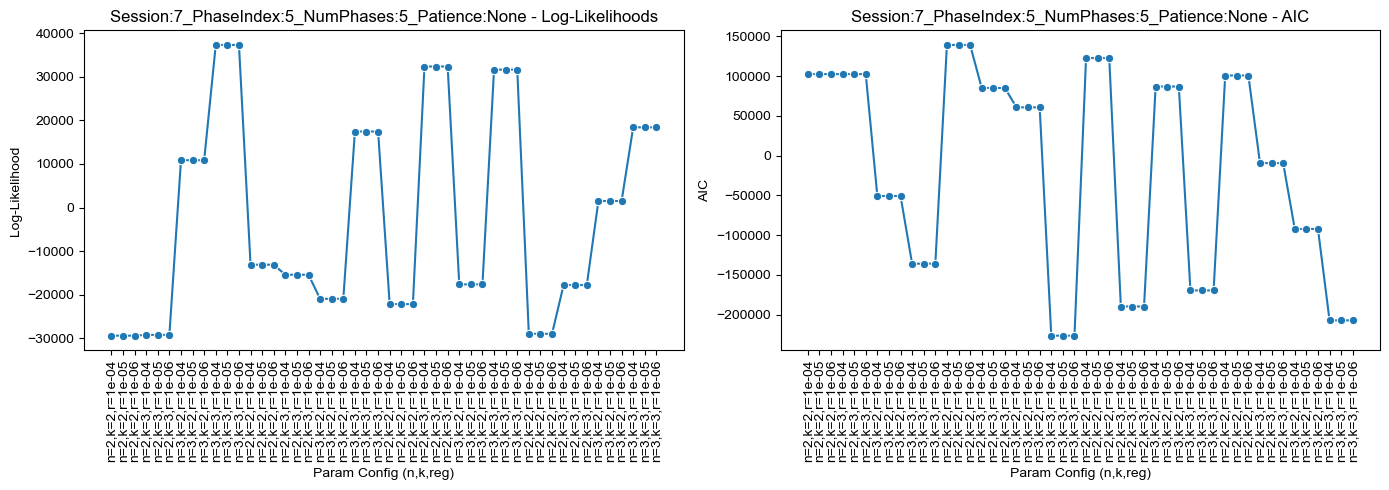

In [54]:
level_2.visualize_cv_results(cv_results)

# Save output file 

In [ ]:
# Define path to the 'csvs' folder and final output file
csv_dir = os.path.join(BASE_PATH, 'csvs','combined')
output_file = os.path.join(csv_dir, 'HHMM_State_file.csv')

# Ensure the 'csvs' directory exists
os.makedirs(csv_dir, exist_ok=True)

# Save the DataFrame
df_hier.to_csv(output_file, index=False)

# Create 4 level HHMM States

In [ ]:
# Assign reward orientation based on session-specific angle medians
df_hier = level_2.assign_reward_orientation(df_hier, angle_col='Targeted_Angle_smooth_abs', level_2_state_col='Level_2_States', session_col='Session')

# Then assign the final HHMM state
df_hier = level_2.assign_hhmm_state(df_hier, level_1_state_col = 'HMM_State' , level_2_state_col = 'Reward_Oriented')

# Observe the raw state sequence

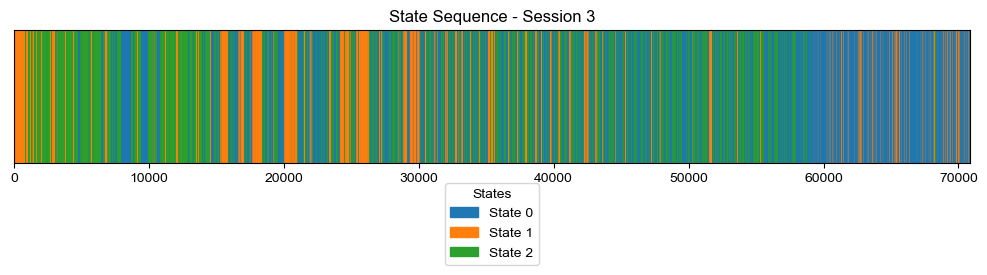

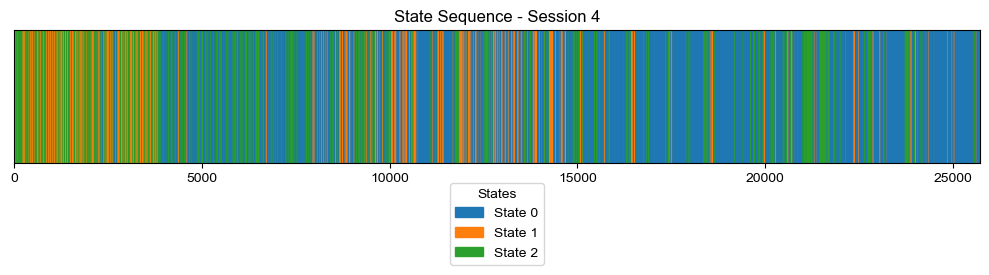

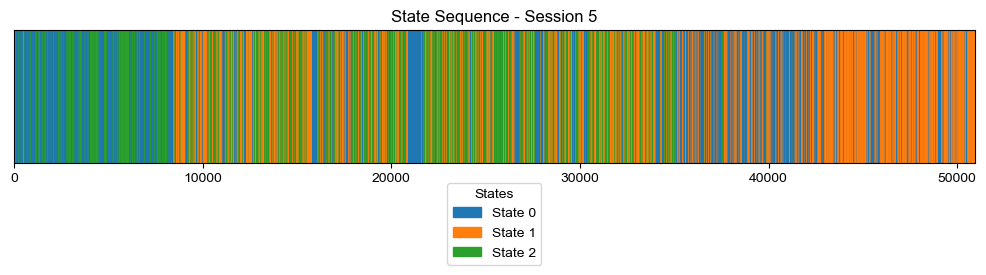

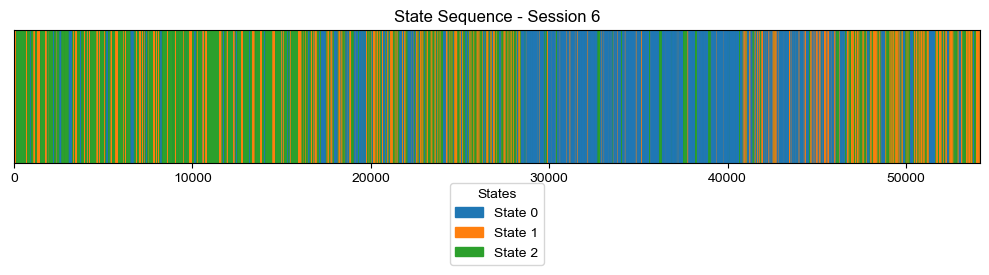

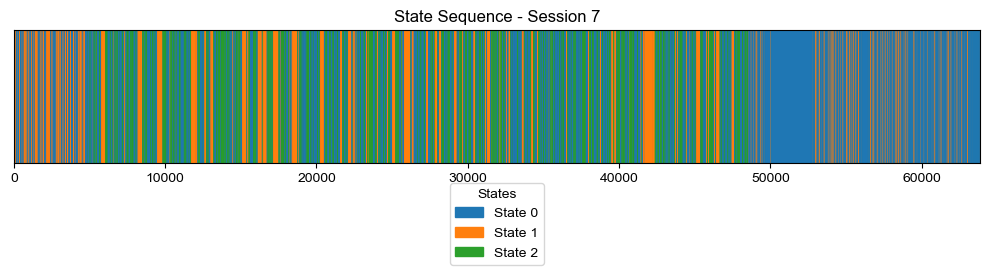

In [53]:
# Plot all sessions
level_2.plot_state_sequences(df_hier,     
    genotype='WT-WT',
    state_col='Level_2_States',
    sessions_to_plot='all',  # Can be 'all', a list of session IDs, or an int (top n)
    title_prefix='State Sequence')

# # Example 2: Plot only top 5 sessions 
# plot_state_sequences(df_hier, genotype='WT-WT', sessions_to_plot=5)

# # Example 3: Plot custom subset of sessions
# plot_state_sequences(df_hier, genotype='WT-WT', sessions_to_plot=[1, 3])

# Observe the HHMM state sequence

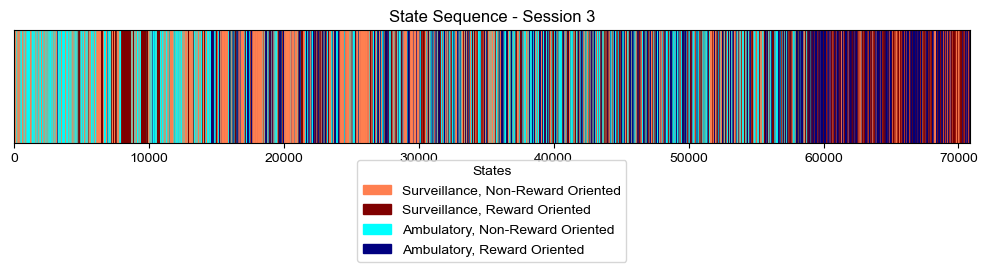

In [43]:
#------------------- SET THESE VALUES ----------------------#
colors = {
    'Surveillance, Non-Reward Oriented': 'coral',
    'Surveillance, Reward Oriented': 'maroon',
    'Ambulatory, Non-Reward Oriented': 'cyan',
    'Ambulatory, Reward Oriented': 'navy',
}


#___________________________________________________________________
# Plot a specific session
level_2.plot_hhmm_state_sequence(df_hier, session_id=3, session_col='Session', state_col='HHMM State', colors=colors)

# # Plot all sessions
# plot_hhmm_state_sequence(df_hier)

# EXTRA: Data Stream analysis

In [ ]:
# # ======================== USAGE EXAMPLE ======================== #
# # This workflow analyzes metrics at decision nodes using normalized values 
# # within each session and bout, and compares across successful vs unsuccessful bouts.


# # Example Workflow:
# # -----------------

# #--------------- SET THESE VALUES --------------#
# feature_cols = ['step','angle','VB_Distance','Targeted_Angle','KDE']

# #________________________________________________________________
# # Step 1: Compute bout-level summary
# index_df = level_2.compute_detailed_bout_summary(
#     df=df_hier,
#     feature_cols=feature_cols,
#     node_filter='Decision (Reward)',
#     state_col='HMM State',
#     target_zone='Target Zone',
#     valid_bout_threshold=10,
#     bout_col='Bout_num'
# )

# # Step 2: Plot measures for successful vs unsuccessful bouts
# level_2.plot_measures_by_bout_type(index_df, feature_cols=feature_cols)
